In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np


Using Theano backend.


In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
# load dataset
dataset = read_csv('building_clean.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,3,9,10,11,12,13,14,15,16]], axis=1, inplace=True)
print(reframed.head())

   var5(t-1)  var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var1(t)   var2(t)  \
1        1.0        0.0        1.0        0.0        1.0      0.0  0.016442   
2        1.0        0.0        1.0        0.0        1.0      0.0  0.016442   
3        1.0        0.0        1.0        0.0        1.0      0.0  0.016442   
4        1.0        0.0        0.5        0.0        1.0      0.0  0.016442   
5        1.0        0.0        0.5        0.0        1.0      0.0  0.016442   

    var3(t)   var4(t)  var5(t)    ...     var8(t)  var9(t)  var10(t)  \
1  0.070404  0.743045      1.0    ...         0.0      1.0  0.666667   
2  0.070404  0.743045      1.0    ...         0.0      1.0  0.666667   
3  0.070404  0.743045      1.0    ...         0.0      1.0  0.666667   
4  0.070404  0.743045      1.0    ...         0.0      1.0  0.666667   
5  0.070404  0.743045      1.0    ...         0.0      1.0  0.666667   

   var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  var16(t)  var17(t)  
1  0.038724  0.320

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 21) (8760,) (2442105, 1, 21) (2442105,)


Train on 8760 samples, validate on 2442105 samples
Epoch 1/40
12s - loss: 0.1448 - val_loss: 0.1807
Epoch 2/40
12s - loss: 0.1210 - val_loss: 0.1221
Epoch 3/40
13s - loss: 0.0754 - val_loss: 0.0927
Epoch 4/40
13s - loss: 0.0329 - val_loss: 0.1233
Epoch 5/40
13s - loss: 0.0265 - val_loss: 0.1007
Epoch 6/40
13s - loss: 0.0198 - val_loss: 0.0868
Epoch 7/40
15s - loss: 0.0365 - val_loss: 0.0809
Epoch 8/40
17s - loss: 0.0232 - val_loss: 0.1142
Epoch 9/40
19s - loss: 0.0327 - val_loss: 0.1018
Epoch 10/40
17s - loss: 0.0200 - val_loss: 0.1444
Epoch 11/40
16s - loss: 0.0280 - val_loss: 0.1021
Epoch 12/40
17s - loss: 0.0206 - val_loss: 0.1660
Epoch 13/40
17s - loss: 0.0266 - val_loss: 0.1234
Epoch 14/40
17s - loss: 0.0287 - val_loss: 0.1019
Epoch 15/40
19s - loss: 0.0248 - val_loss: 0.1274
Epoch 16/40
14s - loss: 0.0229 - val_loss: 0.1401
Epoch 17/40
16s - loss: 0.0282 - val_loss: 0.1155
Epoch 18/40
18s - loss: 0.0232 - val_loss: 0.1221
Epoch 19/40
16s - loss: 0.0199 - val_loss: 0.1335
Epoch 20

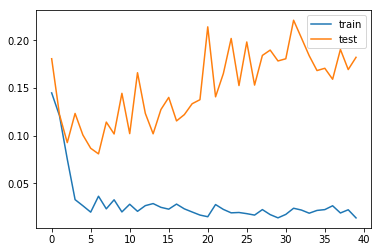

In [6]:
# design network
model = Sequential()
model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 8760 samples, validate on 2442105 samples
Epoch 1/50
17s - loss: 0.1369 - val_loss: 0.1766
Epoch 2/50
18s - loss: 0.1011 - val_loss: 0.0942
Epoch 3/50
16s - loss: 0.0338 - val_loss: 0.0548
Epoch 4/50
17s - loss: 0.0353 - val_loss: 0.0822
Epoch 5/50
19s - loss: 0.0316 - val_loss: 0.0793
Epoch 6/50
19s - loss: 0.0376 - val_loss: 0.0488
Epoch 7/50
16s - loss: 0.0262 - val_loss: 0.0494
Epoch 8/50
16s - loss: 0.0262 - val_loss: 0.0523
Epoch 9/50
17s - loss: 0.0254 - val_loss: 0.0493
Epoch 10/50
16s - loss: 0.0383 - val_loss: 0.0447
Epoch 11/50
17s - loss: 0.0329 - val_loss: 0.0484
Epoch 12/50
17s - loss: 0.0156 - val_loss: 0.0459
Epoch 13/50
18s - loss: 0.0208 - val_loss: 0.0405
Epoch 14/50
16s - loss: 0.0248 - val_loss: 0.0318
Epoch 15/50
18s - loss: 0.0248 - val_loss: 0.0325
Epoch 16/50
16s - loss: 0.0229 - val_loss: 0.0797
Epoch 17/50
17s - loss: 0.0366 - val_loss: 0.0667
Epoch 18/50
17s - loss: 0.0200 - val_loss: 0.0504
Epoch 19/50
16s - loss: 0.0266 - val_loss: 0.0447
Epoch 20

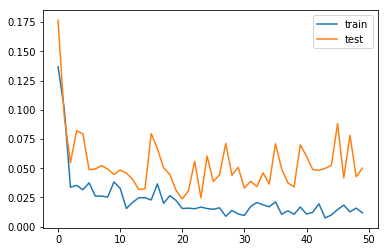

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 8760 samples, validate on 2442105 samples
Epoch 1/60
19s - loss: 0.1377 - val_loss: 0.1701
Epoch 2/60
21s - loss: 0.1029 - val_loss: 0.0678
Epoch 3/60
20s - loss: 0.0479 - val_loss: 0.1067
Epoch 4/60
21s - loss: 0.0457 - val_loss: 0.1301
Epoch 5/60
21s - loss: 0.0380 - val_loss: 0.0801
Epoch 6/60
21s - loss: 0.0278 - val_loss: 0.0653
Epoch 7/60
23s - loss: 0.0193 - val_loss: 0.0516
Epoch 8/60
23s - loss: 0.0235 - val_loss: 0.0558
Epoch 9/60
21s - loss: 0.0244 - val_loss: 0.0465
Epoch 10/60
20s - loss: 0.0153 - val_loss: 0.0774
Epoch 11/60
21s - loss: 0.0287 - val_loss: 0.0780
Epoch 12/60
20s - loss: 0.0358 - val_loss: 0.0930
Epoch 13/60
21s - loss: 0.0390 - val_loss: 0.0890
Epoch 14/60
23s - loss: 0.0380 - val_loss: 0.0944
Epoch 15/60
23s - loss: 0.0295 - val_loss: 0.0841
Epoch 16/60
22s - loss: 0.0266 - val_loss: 0.0877
Epoch 17/60
21s - loss: 0.0292 - val_loss: 0.0840
Epoch 18/60
23s - loss: 0.0305 - val_loss: 0.0709
Epoch 19/60
22s - loss: 0.0298 - val_loss: 0.0671
Epoch 20

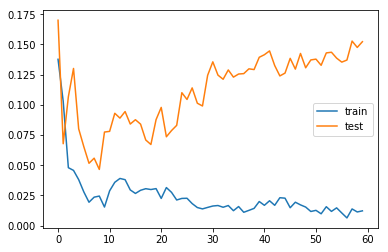

In [8]:
# design network
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 8760 samples, validate on 2442105 samples
Epoch 1/70
17s - loss: 0.1317 - val_loss: 0.1343
Epoch 2/70
18s - loss: 0.0884 - val_loss: 0.0951
Epoch 3/70
18s - loss: 0.0363 - val_loss: 0.1500
Epoch 4/70
19s - loss: 0.0381 - val_loss: 0.1191
Epoch 5/70
20s - loss: 0.0401 - val_loss: 0.0837
Epoch 6/70
20s - loss: 0.0215 - val_loss: 0.0711
Epoch 7/70
19s - loss: 0.0302 - val_loss: 0.0447
Epoch 8/70
19s - loss: 0.0198 - val_loss: 0.0823
Epoch 9/70
19s - loss: 0.0263 - val_loss: 0.0697
Epoch 10/70
19s - loss: 0.0231 - val_loss: 0.0755
Epoch 11/70
19s - loss: 0.0182 - val_loss: 0.1021
Epoch 12/70
19s - loss: 0.0150 - val_loss: 0.0805
Epoch 13/70
22s - loss: 0.0223 - val_loss: 0.0869
Epoch 14/70
24s - loss: 0.0255 - val_loss: 0.1071
Epoch 15/70
20s - loss: 0.0200 - val_loss: 0.1021
Epoch 16/70
20s - loss: 0.0157 - val_loss: 0.1080
Epoch 17/70
21s - loss: 0.0251 - val_loss: 0.0852
Epoch 18/70
20s - loss: 0.0163 - val_loss: 0.0794
Epoch 19/70
20s - loss: 0.0163 - val_loss: 0.1142
Epoch 20

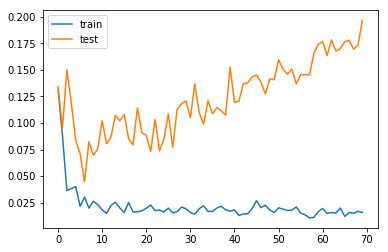

In [7]:
# design network
model = Sequential()
model.add(LSTM(70, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: operands could not be broadcast together with shapes (2442105,21) (17,) (2442105,21) 

In [ ]:
print(test_X)

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# visualize last 100 timesteps of prediction:
pyplot.plot(inv_yhat[-100:])
pyplot.plot(inv_y[-100:])
pyplot.show()